## Intranight Cadence ##

The basic question here is how to drive visits within a night. However, because the intra-night cadence also has implications for the night-to-night revisit rate (assuming all else is equal), we likely want to consider the impacts on the night-to-night revisit rate at the same time. 

In general, more visits within a given night will mean fewer nights with visits, if the overall number of visits is held approximately constant. It also means covering a smaller amount of sky per night. Slewing to blocks of sky further away (for a triplet separated by time from the original pointings) means longer slew times, which means fewer visits in the survey. 

Single visits per night would permit covering the most sky area in each night, but there would be very little transient information -- even slow transients would have problems with confusion with faster transients or moving objects.  Pairs of visits permit some kind of color measurement for transients or variables if the visits are in different filters, and importantly - permit linking moving objects to separate these from stationary objects; previous survey simulation evaluations showed improvements in science evaluation metrics with visits in different filters, so this is the current baseline. However, identifying fast transients as coming from a particular kind of object is likely to require an additional visit within the same or next night in the same filter -- three visits to determine both a color and rate of change of magnitude. This additional visit must be separated from the pair by at least two hours. 

Revisits in different timescales:
* the SRD expresses a desire to detect changes in brightness of objects on timescales of 40 seconds to 30 minutes, in section 3.4.0.2 (aka 'rapid revisits') -- these repeat visits are generally met by revisiting the field for the second visit in a pair AND through field overlaps. The field overlaps result in short timescale re-visits, usually in the same filter, anywhere from 40s (next visit) to 30 minutes (overlaps between visits to contiguous but not 'next visit' areas of sky). This requirement is evaluated in the 'RapidRevisitsMetric', looking for the amount of area that is covered with a specified number of visits in these intervals. This metric always passes the minimum threshold, as long as pointings are adjacent/contiguous (which also reduces slew time, so has multiple benefits). 
* Solar System object linkage drives a second observation somewhere between 30 minutes and ~2 hours (depending on the kind of object, potential confusion with other solar system objects, etc.). This drives the basic pair separation timing, along with an evaluation of how efficient obtaining the second pair becomes as you vary the time until the second pair (see the 'pair timing' sequence out of v1.5/1.7 -- setting the pair timing at 33 minutes resulted in the highest combination of open shutter fraction + rate of acquiring pairs). For efficient linking into longer arcs for preliminary orbit determination, additional pairs of visits are desired in the surrounding days to ~few weeks. These are captured in the SSO discovery metrics, although there is a wide range of phase space to investigate (different orbits, different size objects, etc). 
* Transient classification and variability measurement are the primary drivers for revisits at longer timescales, and the timescales desired vary wildly. In general, there are needs from across a wide swath of science to obtain at least some visits within each year for several years, and we do always obtain some visits per year over the WFD-level areas in the footprint (but these timescales generally fall under the "rolling cadence" category of consideration). Here we're mainly concerned with fast transients, where the timescale for a repeat visit is on the order of a several hours to a day or so. (KNe prefer a triplet visit on the timescale of a day). 

We do not have metrics which are obviously biased toward intervals of observation (in the same bandpass) < 1 day .. except for the less scientifically linked TGapsPercent metric (run on intervals < 1 day) and the FilterPairTgaps metric (coming soon). I am unclear what populations we're missing that would require observations on these shorter timescales.

In [2]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import rubin_sim.maf as maf

In [37]:
families = maf.archive.get_family_descriptions()
family_list = families.index.values
summary_source = 'summary_2022_08_01.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
metrics_source = 'metric_sets.json'
metric_sets = maf.get_metric_sets(metrics_source)
msets = metric_sets.groupby('metric set').first().index.to_list()
msets

['AGN N QSO',
 'AGN SF',
 'AGN SF DDF',
 'AGN short',
 'AGN timelag',
 'DDF Cadence',
 'DESC WFD',
 'GP filters',
 'GP footprint',
 'GP season',
 'GP visit',
 'N Visits',
 'SCOC',
 'SL TDC',
 'SRD',
 'SSO N Objs',
 'SSO discovery',
 'SSO discovery options',
 'SSO fraction 3 bands',
 'SSO fraction 4 bands',
 'SSO fraction 5 bands',
 'SSO fraction 6 bands',
 'SSO lightcurve inversion',
 'Stars',
 'TVS KNe',
 'TVS KNe short',
 'TVS PeriodModulation',
 'TVS PeriodicDetect',
 'TVS Presto',
 'TVS TDE',
 'TVS Tgaps',
 'TVS XRB',
 'TVS anomalies',
 'TVS microlensing all',
 'TVS microlensing short',
 'TVS short',
 'WFD Depths',
 'cadence',
 'galaxies',
 'plot areas',
 'radar',
 'short description']

In [47]:
fams = ['triplets', 'long gaps no pairs', 'suppress repeats', 'rolling']
baseline_run = 'baseline_v2.0_10yrs'
these_runs = np.concatenate([[baseline_run], families.explode('run').loc[fams, 'run']])

lines = maf.find_family_lines(families, fams) + 1
lines = np.concatenate([[1, 13, 25], lines])

In [48]:
# Basic family information
for fam in fams:
    maf.describe_families(families.loc[[fam], :],
                            summary=summaries,
                            table_metric_set=metric_sets.loc["short description"],
                            plot_metric_set=None,
                            baseline_run=families.loc[fam, "reference"],)

---
**triplets** : These simulations add a third visit within each night, with variations on the time interval between the first pair of visits (standard separation of 33 minutes) to the third visit. The third visit is always acquired in the same filter as one of the earlier visits in the pair. Only *some* of the visits in the night are taken in triplets; the first "blob" will be a triplet, and depending on the time available in the night and the gap length, sometimes additional blobs will be acquired in triplets. The "presto_gap" runs take triplets all the time, at a set interval to the third visit and in the filter pairs described in the brief descriptions. The "presto_half" runs are similar, but only take triplets of visits about half of the time. The "long_gaps" runs vary the interval to the third visit, and generally have longer gaps of 2 to 7 hours. The long_gaps run take triplets at a variety of frequencies, ranging from every night to every few nights; in some simulations the triplets do not start until year 5.  
**version**: 2.0  
**runs**:  


,brief,Area with >825 visits/pointing (fO_Area),Unextincted area i>25.9,Nvisits total,Median Nvis over top 18k (fO_Nv Med),Median Nvis u band,Median Nvis g band,Median Nvis r band,Median Nvis i band,Median Nvis z band,Median Nvis y band
run,,,,,,,,,,,
presto_gap1.5_v2.0_10yrs,"Triples spaced 1.5 hours apart g+r,r+i,i+z initial pairs",2177.97,12137.03,1991926.0,790.0,17.0,76.0,173.0,183.0,154.0,152.0
presto_gap2.0_v2.0_10yrs,"Triples spaced 2.0 hours apart g+r,r+i,i+z initial pairs",3255.62,11658.63,2004698.0,798.0,25.0,75.0,173.0,182.0,154.0,153.0
presto_gap2.5_v2.0_10yrs,"Triples spaced 2.5 hours apart g+r,r+i,i+z initial pairs",2386.95,12485.33,1986054.0,792.0,28.0,74.0,172.0,179.0,152.0,152.0
presto_gap3.0_v2.0_10yrs,"Triples spaced 3.0 hours apart g+r,r+i,i+z initial pairs",2732.74,12722.01,1986782.0,794.0,30.0,73.0,172.0,178.0,153.0,152.0
presto_gap3.5_v2.0_10yrs,"Triples spaced 3.5 hours apart g+r,r+i,i+z initial pairs",3034.05,12541.56,1992713.0,796.0,31.0,73.0,172.0,177.0,153.0,153.0
presto_gap4.0_v2.0_10yrs,"Triples spaced 4.0 hours apart g+r,r+i,i+z initial pairs",3530.07,12735.44,1998152.0,799.0,36.0,72.0,173.0,177.0,153.0,153.0
presto_gap1.5_mix_v2.0_10yrs,"Triples spaced 1.5 hours apart g+i,r+z,i+y initial pairs",1400.78,15687.24,1977886.0,787.0,19.0,71.0,171.0,176.0,159.0,159.0
presto_gap2.0_mix_v2.0_10yrs,"Triples spaced 2.0 hours apart g+i,r+z,i+y initial pairs",2426.40,15796.35,1995049.0,795.0,26.0,71.0,172.0,176.0,158.0,160.0
presto_gap2.5_mix_v2.0_10yrs,"Triples spaced 2.5 hours apart g+i,r+z,i+y initial pairs",1822.11,15860.13,1978530.0,790.0,30.0,70.0,170.0,173.0,156.0,158.0


---
**long gaps no pairs** : The baseline survey strategy takes pairs of visits every few nights, wherethe pair is separated by about 33 minutes. The pairs are taken in mixed filters, for color measurements. These simulations extend the gap between the pair of visits, for the FIRST pair "blob" of the night, modifying it to a variable time period of between 2 to 7 hours. The pair of visits are both in the same filter, in any of griz (g+r, r+i, or i+z pairs). In some of the simulations, these long gap visits are obtained throughout the survey, while for other simulations the longer time separations do not start until year 5.  
**version**: 2.0  
**runs**:  


,brief,Area with >825 visits/pointing (fO_Area),Unextincted area i>25.9,Nvisits total,Median Nvis over top 18k (fO_Nv Med),Median Nvis u band,Median Nvis g band,Median Nvis r band,Median Nvis i band,Median Nvis z band,Median Nvis y band
run,,,,,,,,,,,
long_gaps_np_nightsoff7_delayed1827_v2.0_10yrs,Long gaps pairs every 7 nights starting after year 5,12520.58,16675.93,2084679.0,837.0,53.0,70.0,177.0,179.0,160.0,166.0
long_gaps_np_nightsoff6_delayed1827_v2.0_10yrs,Long gaps pairs every 6 nights starting after year 5,12443.37,16766.57,2083998.0,837.0,53.0,69.0,177.0,179.0,160.0,166.0
long_gaps_np_nightsoff5_delayed1827_v2.0_10yrs,Long gap pairs every 5 nights starting after year 5,12414.83,16655.78,2083679.0,837.0,53.0,70.0,177.0,179.0,160.0,166.0
long_gaps_np_nightsoff4_delayed1827_v2.0_10yrs,Long gap pairs every 4 nights starting after year 5,12335.94,16678.44,2082707.0,837.0,53.0,70.0,177.0,179.0,160.0,166.0
long_gaps_np_nightsoff3_delayed1827_v2.0_10yrs,Long gap pairs every 3 nights starting after year 5,12362.80,16618.85,2082329.0,837.0,53.0,70.0,177.0,179.0,160.0,165.0
long_gaps_np_nightsoff2_delayed1827_v2.0_10yrs,Long gap pairs every 2 nights starting after year 5,12073.24,16607.10,2080554.0,836.0,53.0,70.0,177.0,179.0,160.0,165.0
long_gaps_np_nightsoff1_delayed1827_v2.0_10yrs,Long gap pairs every other night starting after year 5,11339.70,16539.12,2075040.0,833.0,52.0,69.0,177.0,178.0,160.0,164.0
long_gaps_np_nightsoff0_delayed1827_v2.0_10yrs,Long gap pairs every night starting after year 5,9217.12,15952.45,2059335.0,825.0,48.0,70.0,176.0,176.0,159.0,160.0
long_gaps_np_nightsoff7_delayed-1_v2.0_10yrs,Long gaps pairs every 7 nights,12246.97,16623.89,2082384.0,837.0,53.0,69.0,177.0,179.0,160.0,166.0


---
**suppress repeats** : This family of simulations adds a basis function to suppress repetition of visits to pointings on the sky which have already been observed in the same night. In the baseline, there are on the order of 20% of pointings which are observed 3 or more times per night (instead of only 2), so this basis function redistributes the "extra" 10% of visits into different nights, changing the inter-night cadence or season length.  
**version**: 2.1  
**runs**:  


,brief,Area with >825 visits/pointing (fO_Area),Unextincted area i>25.9,Nvisits total,Median Nvis over top 18k (fO_Nv Med),Median Nvis u band,Median Nvis g band,Median Nvis r band,Median Nvis i band,Median Nvis z band,Median Nvis y band
run,,,,,,,,,,,
no_repeat_rpw-1.0_v2.1_10yrs,Baseline but suppress repeats of pointings within the night by rpw 1.0,12360.28,16983.95,2078336.0,837.0,54.0,69.0,179.0,181.0,159.0,165.0
no_repeat_rpw-2.0_v2.1_10yrs,Baseline but suppress repeats of pointings within the night by rpw 2.0,12258.72,17003.25,2077671.0,837.0,54.0,69.0,179.0,181.0,159.0,165.0
no_repeat_rpw-5.0_v2.1_10yrs,Baseline but suppress repeats of pointings within the night by rpw 5.0,12158.01,16900.86,2076775.0,836.0,54.0,69.0,179.0,182.0,159.0,165.0
no_repeat_rpw-10.0_v2.1_10yrs,Baseline but suppress repeats of pointings within the night by rpw 10.0,12262.08,16908.41,2077379.0,836.0,54.0,68.0,179.0,181.0,159.0,165.0
no_repeat_rpw-20.0_v2.1_10yrs,Baseline but suppress repeats of pointings within the night by rpw 20.0,11854.18,16956.25,2076942.0,835.0,54.0,68.0,178.0,181.0,159.0,165.0
no_repeat_rpw-100.0_v2.1_10yrs,Baseline but suppress repeats of pointings within the night by rpw 100.0,12038.83,16902.53,2077286.0,836.0,54.0,69.0,178.0,182.0,159.0,165.0


---
**rolling** : The rolling family covers a wide variety of rolling cadence variations. These are arranged in general estimation of the impact of the rolling cadence, from "least" to "most" - no_roll has no rolling cadence at all, then variations on the number of stripes (ns=2/3/6) are added, as as which areas of the sky (WFD only, adding the bulge WFD-area, all-sky). The strength of rolling is also varied (rw=50,80 or 90%).  
**version**: 2.0  
**runs**:  


,brief,Area with >825 visits/pointing (fO_Area),Unextincted area i>25.9,Nvisits total,Median Nvis over top 18k (fO_Nv Med),Median Nvis u band,Median Nvis g band,Median Nvis r band,Median Nvis i band,Median Nvis z band,Median Nvis y band
run,,,,,,,,,,,
noroll_v2.0_10yrs,v2.0 baseline with no rolling,12558.35,17005.77,2083375.0,837.0,54.0,70.0,177.0,180.0,160.0,166.0
rolling_ns2_rw0.5_v2.0_10yrs,Rolling half-sky (2 regions) 50%,12614.58,16807.69,2084510.0,838.0,54.0,69.0,177.0,180.0,160.0,166.0
rolling_ns3_rw0.5_v2.0_10yrs,Rolling third-sky (3 regions) 50%,12729.57,16873.16,2085499.0,838.0,54.0,70.0,177.0,180.0,160.0,166.0
rolling_ns2_rw0.9_v2.0_10yrs,Rolling half-sky (2 regions) 90%,12893.23,16711.18,2086980.0,839.0,54.0,70.0,178.0,180.0,160.0,166.0
rolling_ns3_rw0.9_v2.0_10yrs,Rolling third-sky (3 regions) 90%,13255.80,16568.50,2090909.0,841.0,54.0,70.0,178.0,181.0,160.0,167.0
rolling_bulge_ns2_rw0.5_v2.0_10yrs,"Roll in the bulge with 2 regions, 50%",12600.32,16868.96,2084413.0,838.0,54.0,69.0,177.0,180.0,160.0,166.0
rolling_bulge_ns2_rw0.8_v2.0_10yrs,"Roll in the bulge with 2 regions, 80%",12733.76,16664.18,2086550.0,838.0,54.0,70.0,178.0,180.0,161.0,166.0
rolling_bulge_ns2_rw0.9_v2.0_10yrs,"Roll in the bulge with 2 regions, 90%",12940.23,16706.14,2087907.0,840.0,54.0,70.0,178.0,180.0,160.0,166.0
rolling_all_sky_ns2_rw0.9_v2.0_10yrs,Roll on all parts of the sky,12900.78,16599.55,2088105.0,839.0,54.0,69.0,178.0,180.0,160.0,166.0


Let's first look at some basic number of visit and visit depth metrics for the WFD. 

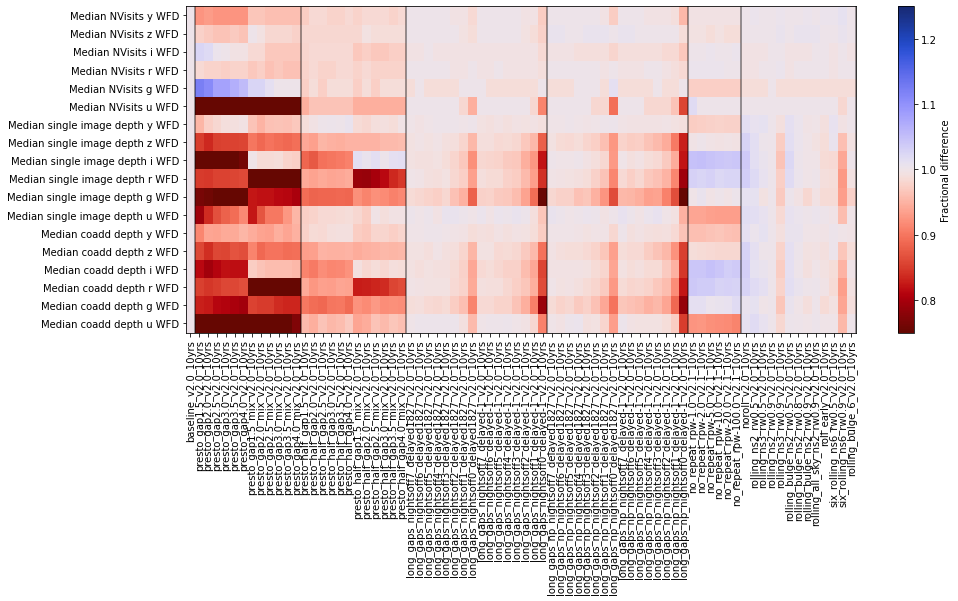

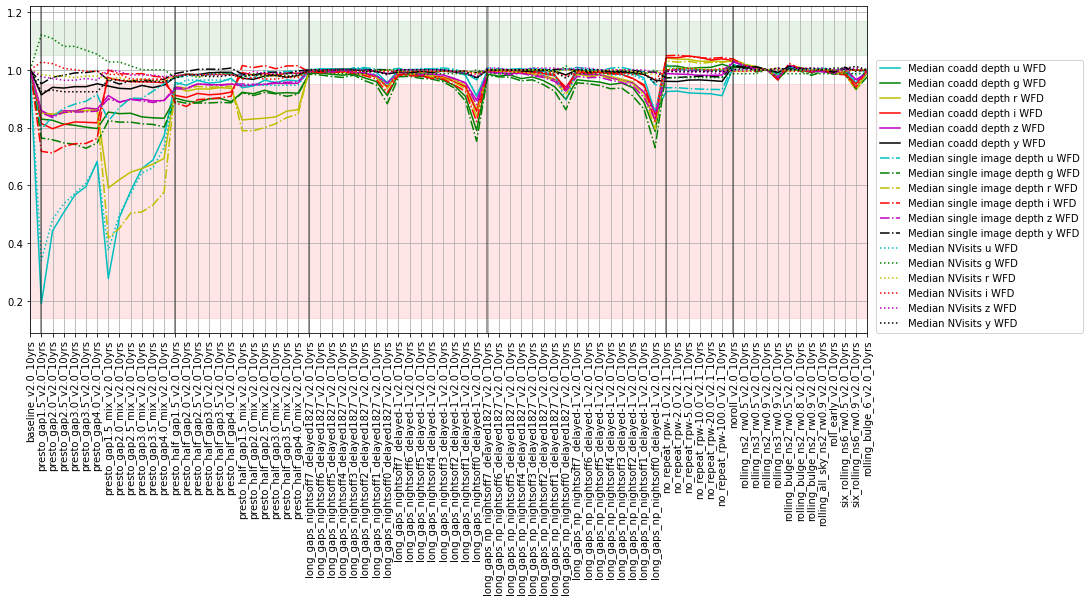

In [49]:
k = 'WFD Depths'

# Plot two versions of the figures
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_sets.loc[k]['short_name'],
                                   metric_set=metric_sets.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                              baseline_run=baseline_run,
                              metric_set=metric_sets.loc[k],
                              metric_label_map=metric_sets.loc[k]['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')

for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

Right away it is noticeable that the presto and presto_half series results in fewer visits per pointing in all filters except g (where a boost in visits per pointing occur) and the median individual image depth decreases. 
Let's look at why the number of visits may be decreasing -- most likely it's a slewtime increase (due to having to slew back to the previous pointing*).

(I did look at if the number of filter changes increased with different triplet gaps, but it's highly variable. It doesn't seem like the number of filter changes is driving the slewtime changes, but rather that it's likely the actual slewing back to the previous pair pointing on the sky.)

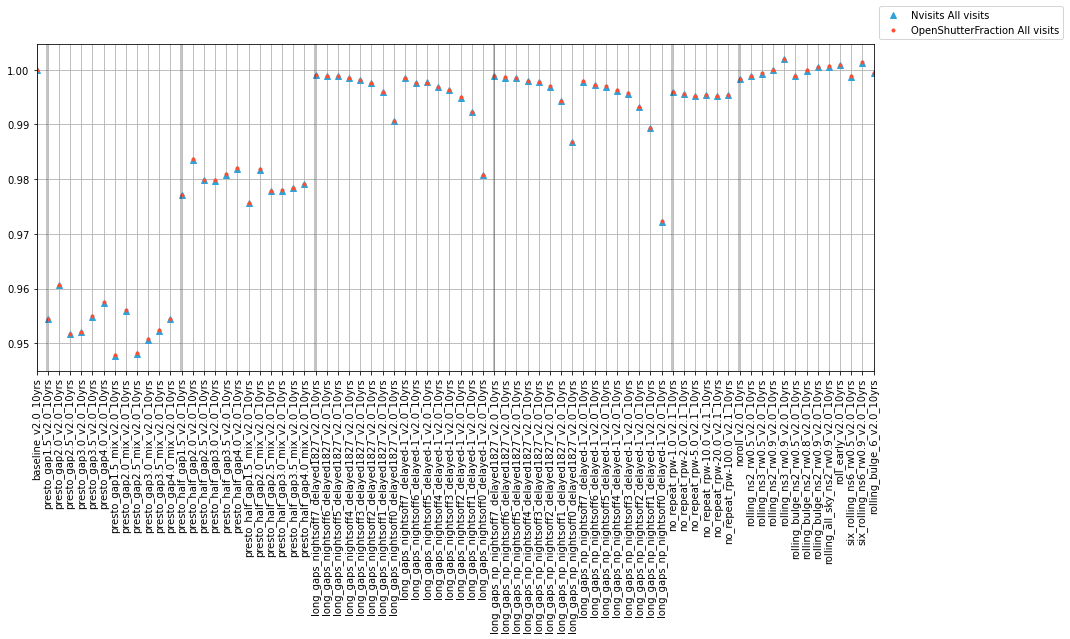

In [51]:
metrics = [ 'Nvisits All visits', 'OpenShutterFraction All visits',] #'Filter Changes Whole Survey']

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metrics],
                              baseline_run = baseline_run,
                              linestyles=None,
                              markers=['^', '.', 'x'],
                             shade_fraction=None,
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.3)

The presto_gapX and presto_gapX_mix both attempt to get triplets of visits as many times as possible in each night, and this seems to always decrease the open shutter fraction by a similar amount (~ 4.5%), no matter how long the gap. 
The presto_half_gapx and presto_half_gapX_mix attempt to get triplets on half of the nights, which again has an impact on the open shutter fraction (~ 2%). 
The open-shutter fraction drop translates directly to 4.5% or 2% fewer visits total in the survey. 

The simulations with very long gaps (long_gap_) triplets do not have as much of an impact on the total number of visits, but not as many visits are joined into triplets. In this family, only the first pair of the night attempts a triplet, and then only on as many nights as "nightsoff" corresponds to -- so nightsoff0 is every night, and has a higher impact on the level of 2%, while nightsoff7 is once per week and is extremely negligle.

The supress repeats and rolling cadence have no significant impact on the open shutter fraction or total number of visits.

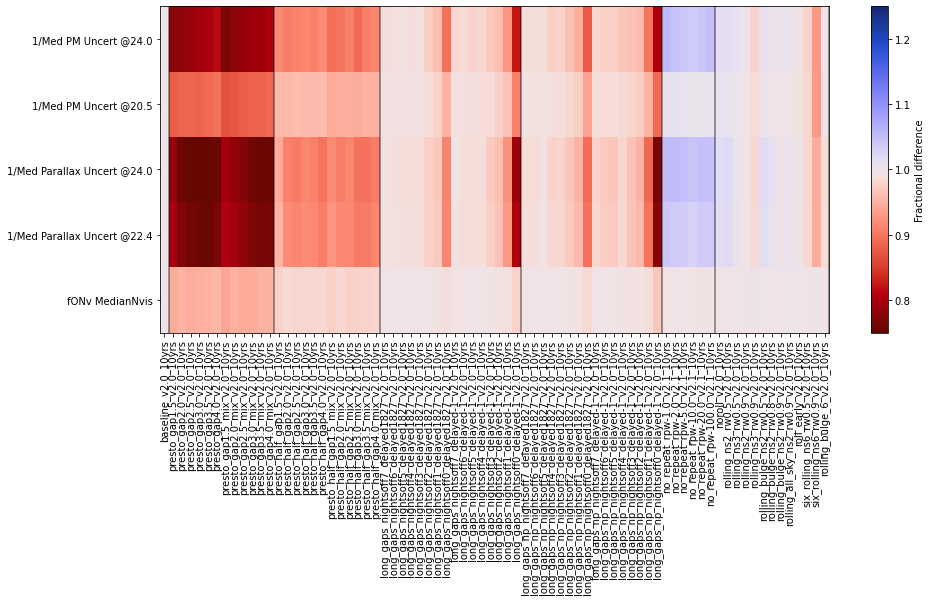

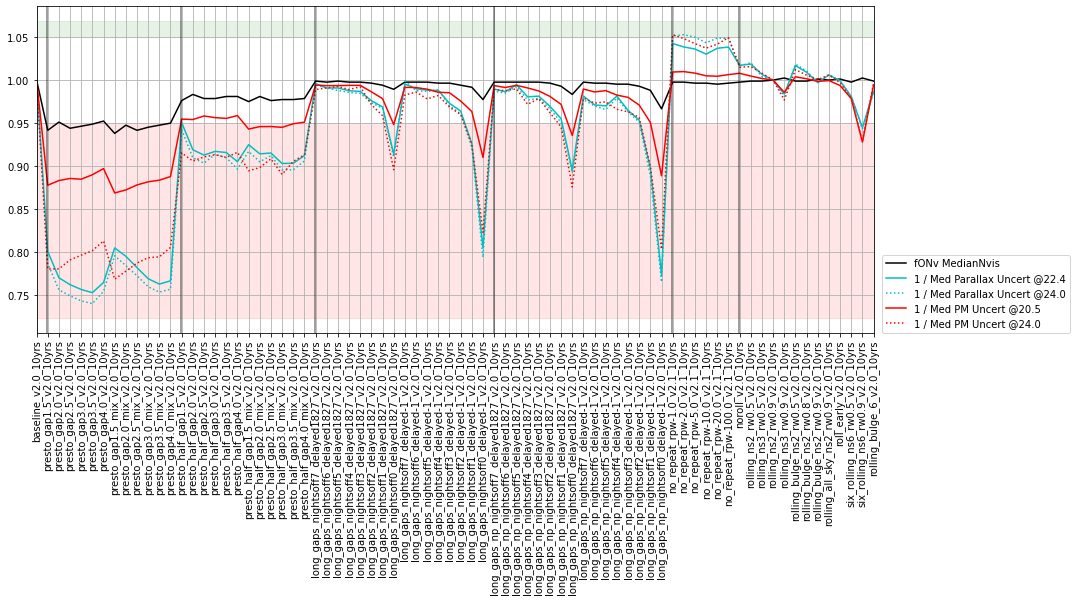

In [52]:
# Let's look at some basic SRD metrics
k = 'SRD'

# Plot two versions of the figures
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_sets.loc[k]['short_name'],
                                   metric_set=metric_sets.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                              baseline_run=baseline_run,
                              metric_set=metric_sets.loc[k],
                              metric_label_map=metric_sets.loc[k]['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

Fewer visits is just bad for our basic SRD metrics, which overall do scale with number of visits. Spreading visits across more nights (in the supresss repeats family) tends to be good, as most metrics prefer visits spaced further apart in time than a few hours. 

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/runComparison/summary_plots.py:326: UserWarning: There are infinite values in the plot of Median TgapsPercent_2-14hrs u band.
  warnings.warn(f"There are infinite values in the plot of {idx}.")
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/runComparison/summary_plots.py:326: UserWarning: There are infinite values in the plot of Median TgapsPercent_2-14hrs g band.
  warnings.warn(f"There are infinite values in the plot of {idx}.")


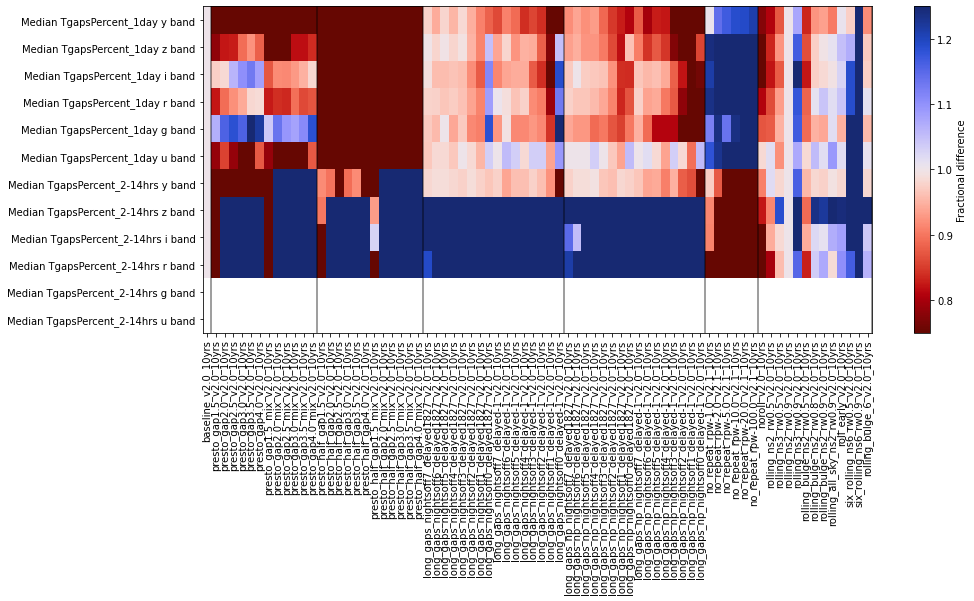

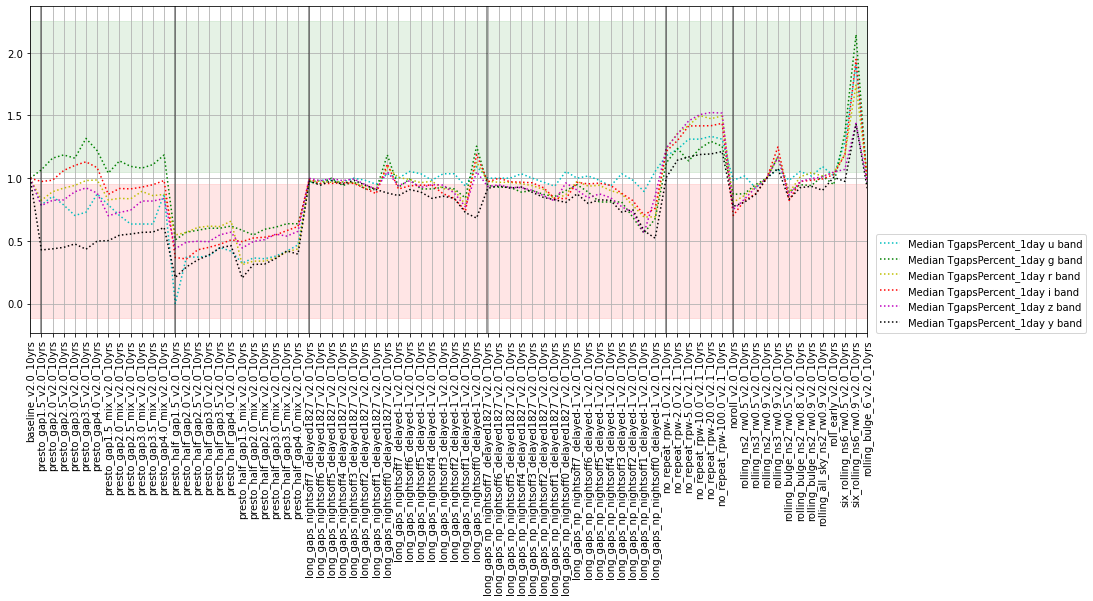

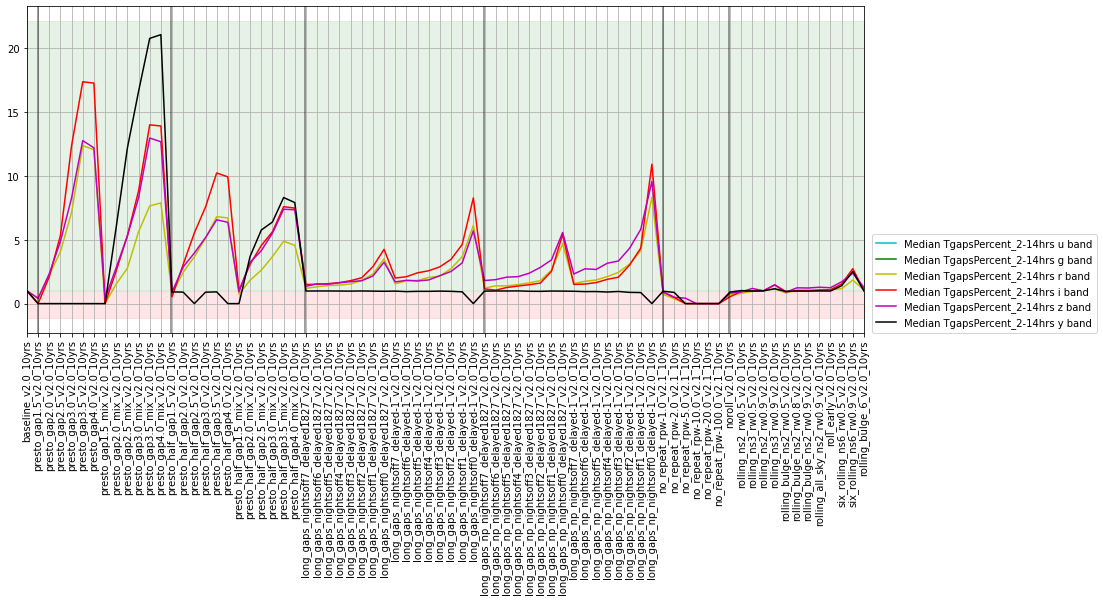

In [53]:
k = 'TVS Tgaps'

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_sets.loc[k]['short_name'],
                                   metric_set=metric_sets.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

msub = metric_sets.loc[k].query('metric.str.contains("day")')
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']], 
                              baseline_run=baseline_run,
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)
    

msub = metric_sets.loc[k].query('metric.str.contains("hrs")')
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']], 
                              baseline_run=baseline_run,
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

These metrics are somewhat "special" in that they are merely measuring the interval between visits, rather than linking it with any particular science. 

With triplets in the same night, we can have a higher fraction of overall deltaT between visits occuring between 2-14 hours. With supress revisits, the deltaT within one night plummets, but the number of return visits at a one-day interval increases. 

Rolling cadence is not generally expected to have effects on either of these timescales -- going from no rolling with a ~4 day revisit interval to 2 or 3 band rolling cadence, we'd expect the interval between revisits to drop to about 2 days, but not necessarily shorter. With a 6-band rolling cadence, yes, the revisit interval could drop to one day on average. We see that the fraction of deltaT between visits in the 2-14 hour interval also increases with 6-band rolling cadence; this is likely due to the lack of overall sky area available at any time in a 6-band rolling cadence. 

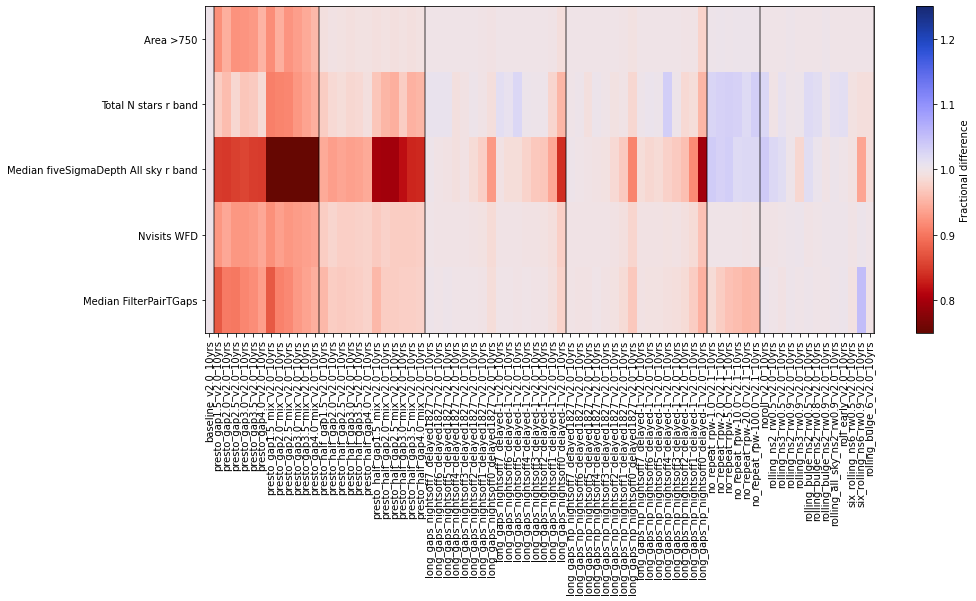

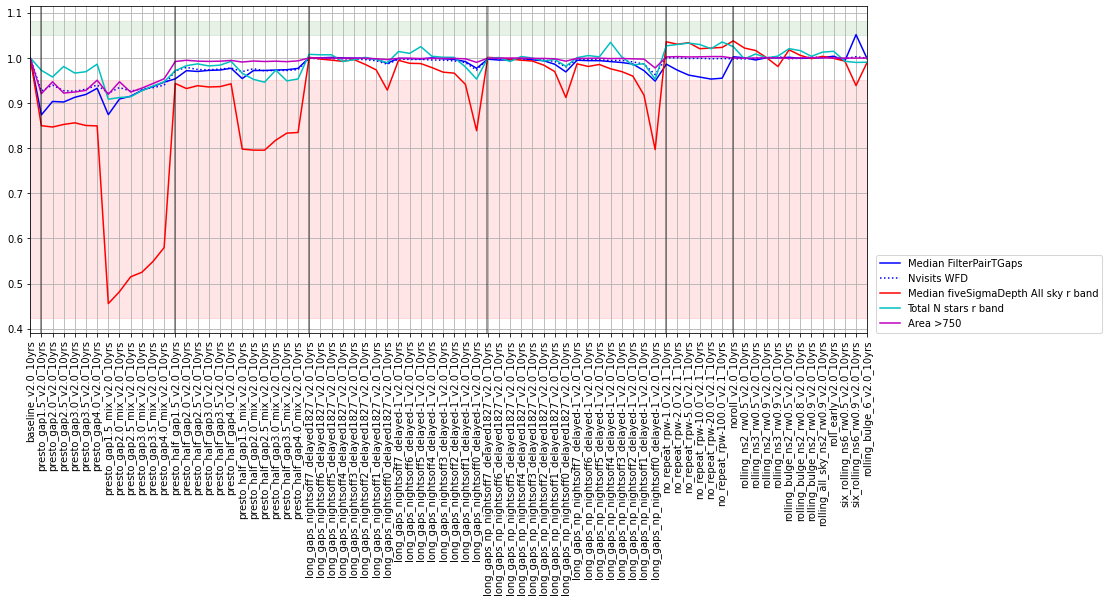

In [54]:
k = 'TVS anomalies'

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_sets.loc[k]['short_name'],
                                   metric_set=metric_sets.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                              baseline_run=baseline_run,
                              metric_set=metric_sets.loc[k],
                              metric_label_map=metric_sets.loc[k]['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

This is a set of metrics which together are intended to evaluate how much discovery space for "unknown unknowns" exists. The area of the survey and the typical depth of a single visit are obvious considerations, and the total number of stars discovered relates to the coadded depth and location of the footprint. The FilterPairTGaps metric itself looks at how many pairs of visits in particular filters occur within expected time gaps and if they are distributed evenly over the range of a few days (for different filters) or over the full survey lifetime (for same filters); the "bins" of time are logarithmically spaced. The details of how this metric responds to these surveys is still being investigated by the metric authors. 

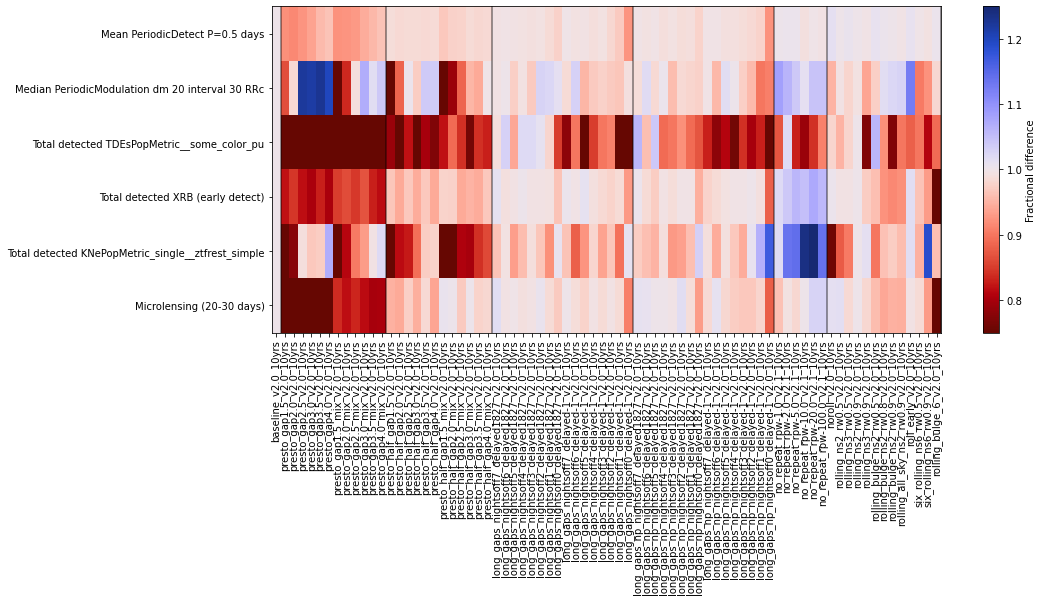

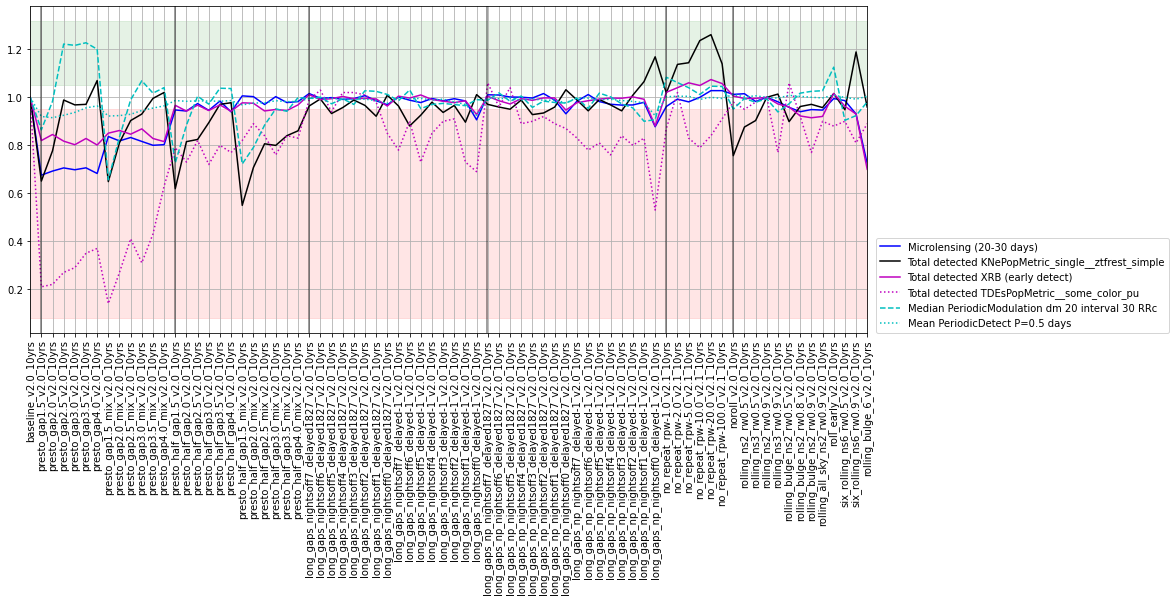

In [55]:
k = 'TVS short'

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_sets.loc[k]['short_name'],
                                   metric_set=metric_sets.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

msub = metric_sets.loc[k]
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']], 
                              baseline_run=baseline_run,
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)


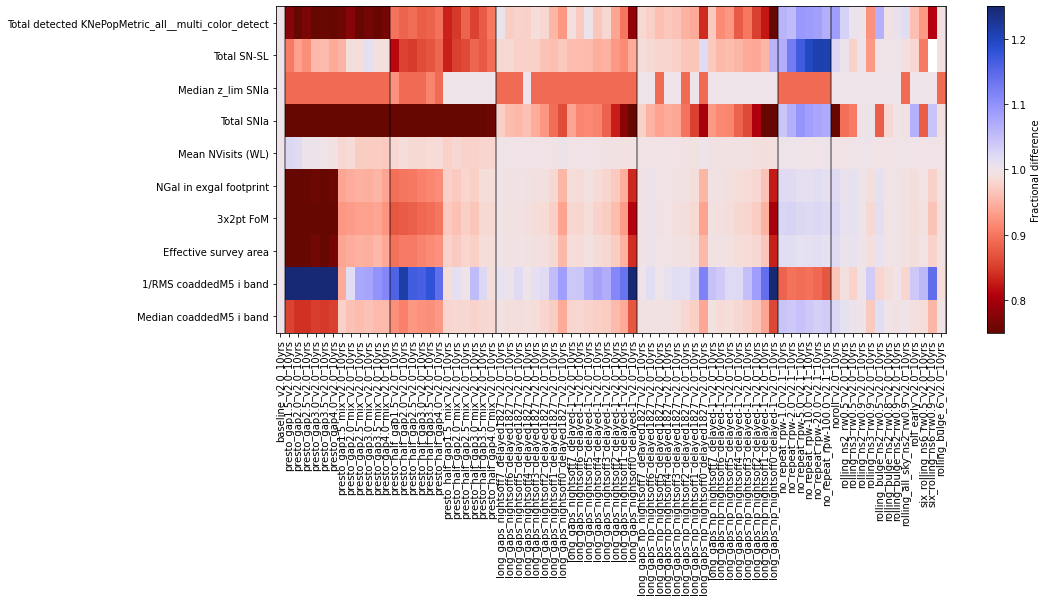

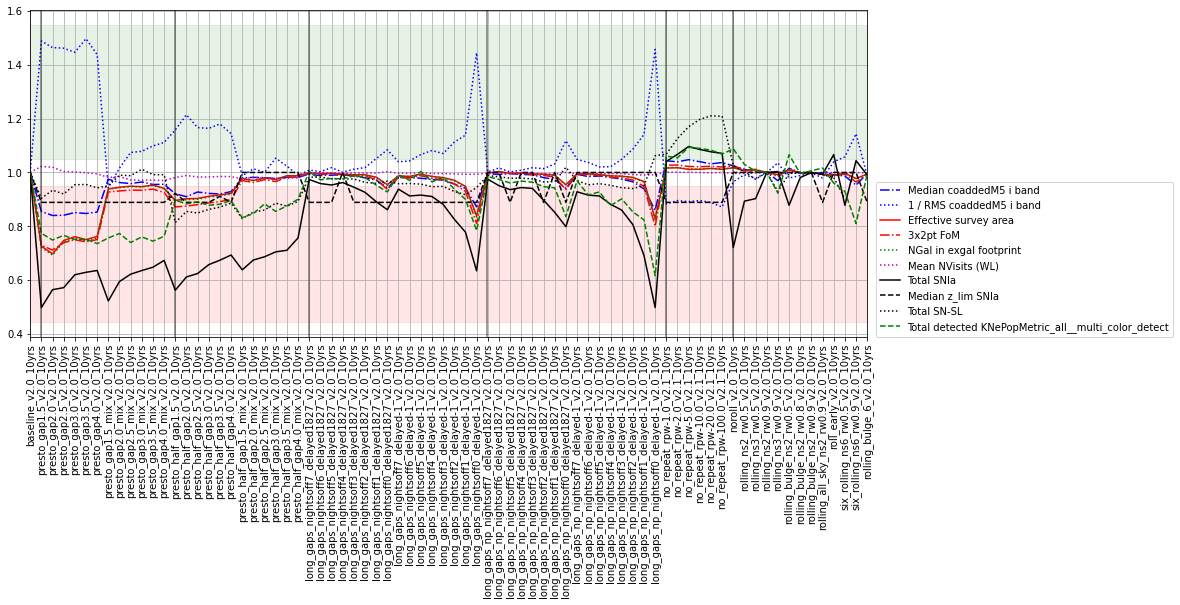

In [56]:
k = 'DESC WFD'

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_sets.loc[k]['short_name'],
                                   metric_set=metric_sets.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

msub = metric_sets.loc[k]
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']], 
                              baseline_run=baseline_run,
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

So the thing to watch out for here is that DESC are not ready to sign off on the SN metric. I suspect in general the trends will be quite similar however (they may differ slightly in magnitude).  
The SLSN authors have requested some updates (in general they think it's ok, but that it doesn't capture rolling cadence properly). 
The KNe metric is configured acceptably, but the authors would request some tweaks if we rerun it (this shouldn't change the results by much).

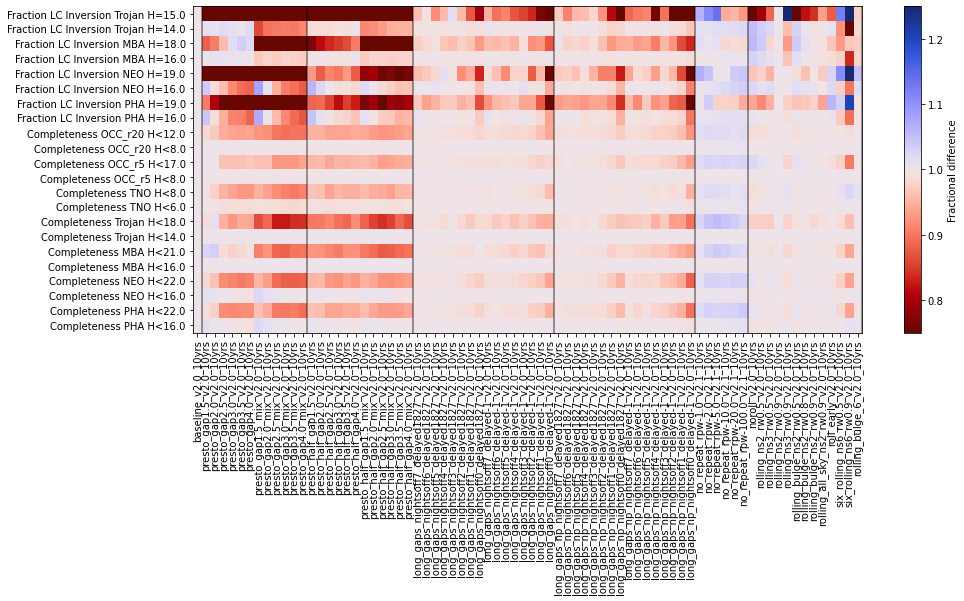

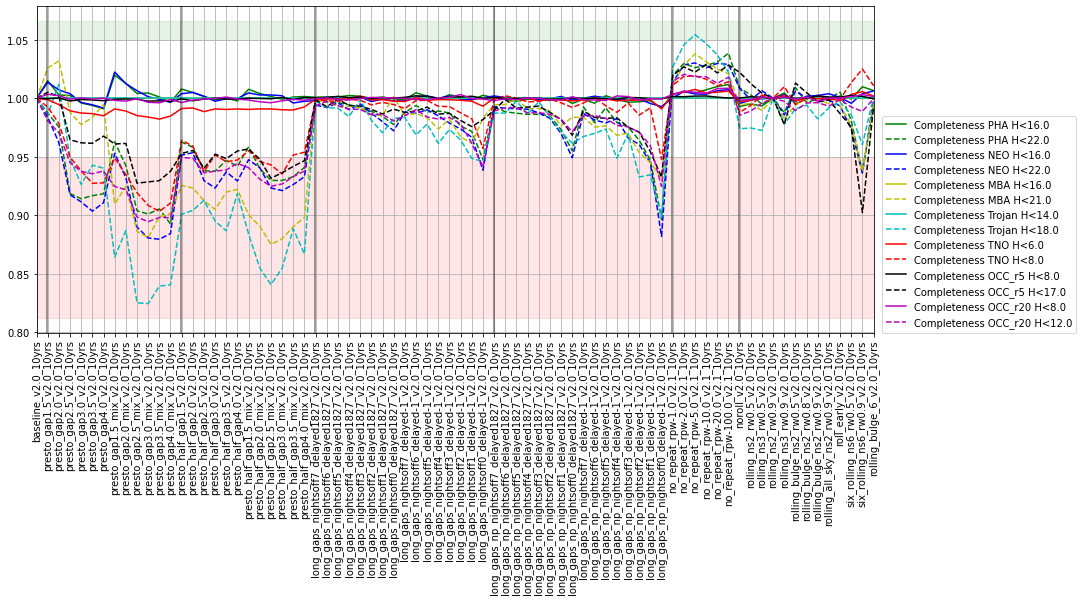

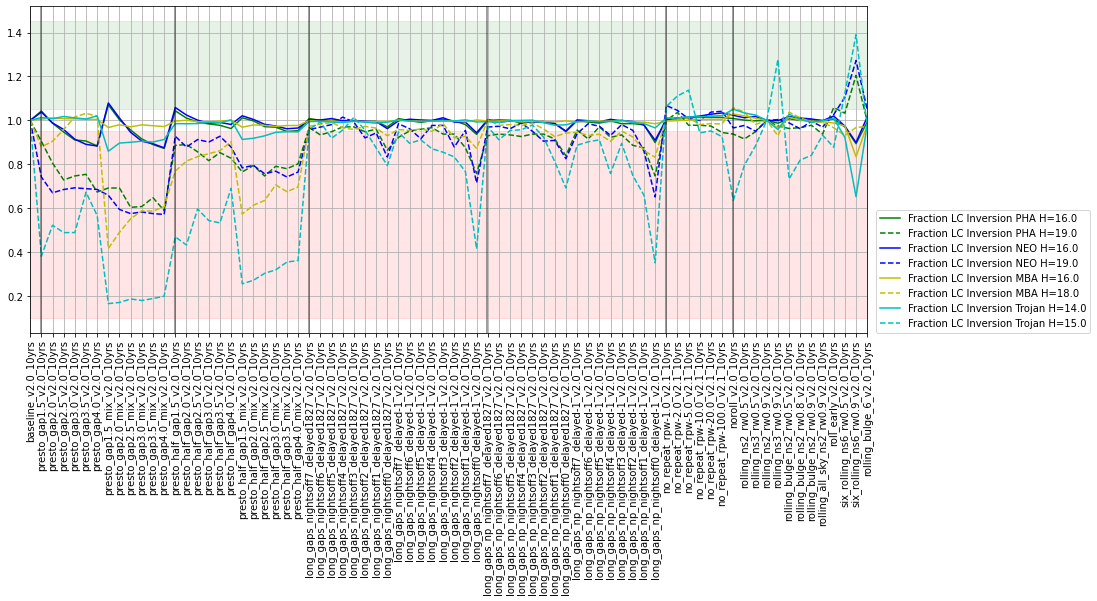

In [57]:
k = ['SSO discovery', 'SSO lightcurve inversion']

msub = metric_sets.loc[k].reset_index('metric set')
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, msub['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

for kk in k:
    msub = metric_sets.loc[kk]
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=msub,
                                  metric_label_map=msub['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    #ax.set_ylim(0.5, 1.5)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
    for l in lines:
        ax.axvline(l-0.05, color='k', alpha=0.5)

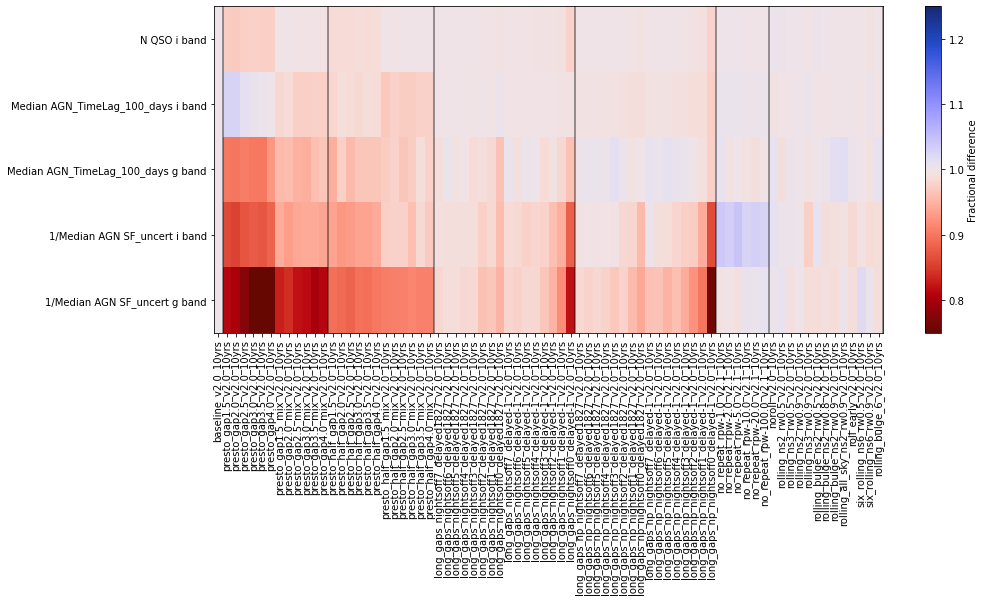

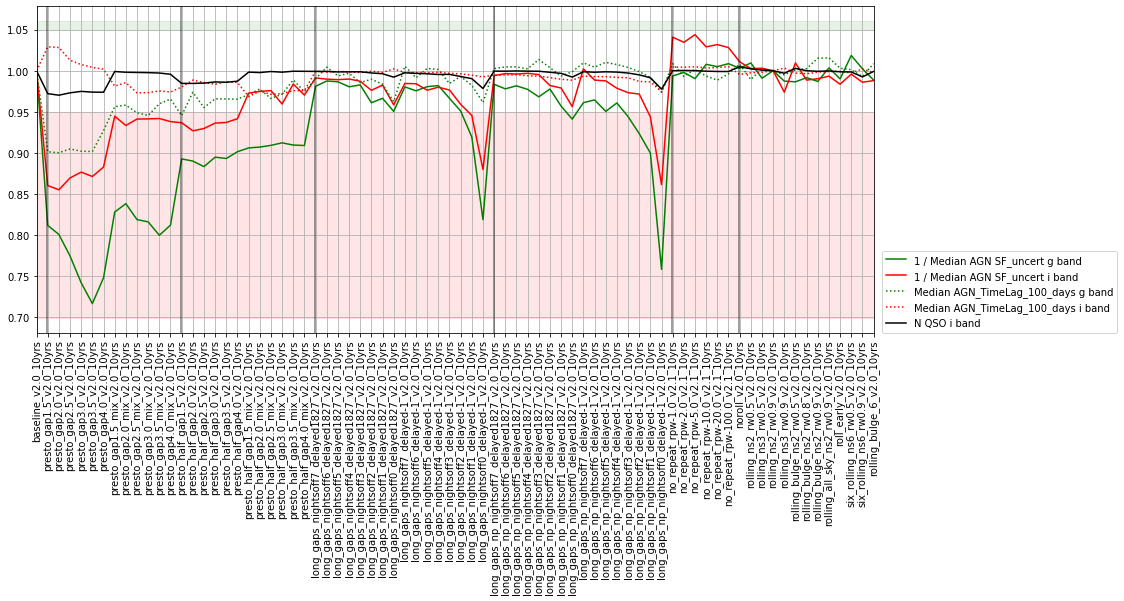

In [58]:
k = 'AGN short'

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_sets.loc[k]['short_name'],
                                   metric_set=metric_sets.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

msub = metric_sets.loc[k]
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']], 
                              baseline_run=baseline_run,
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

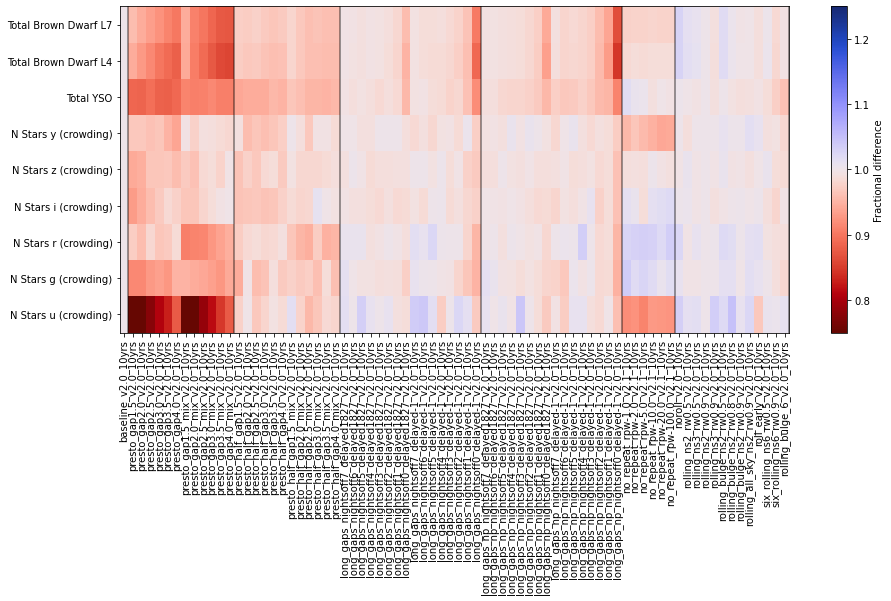

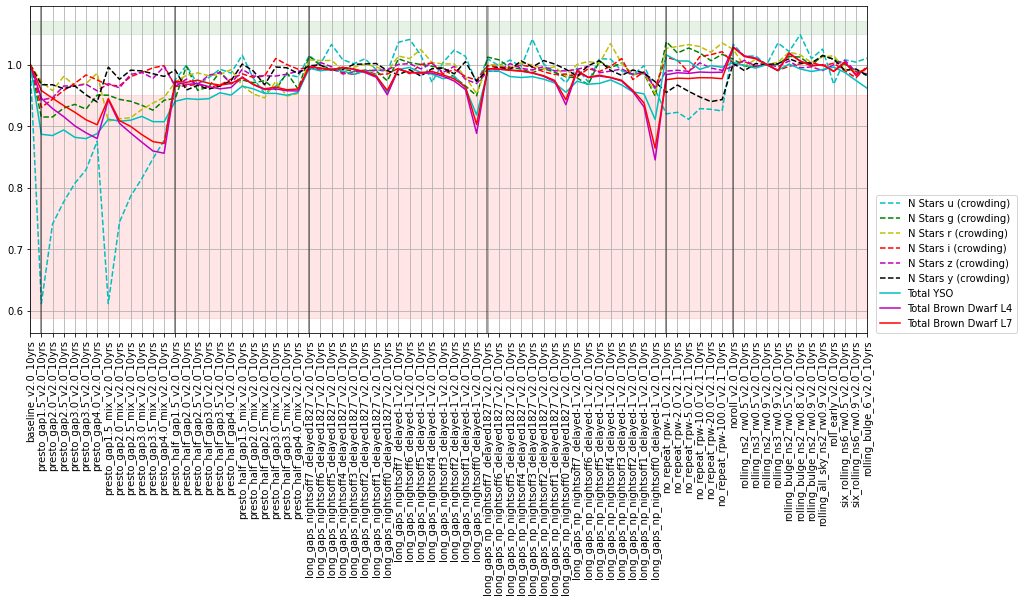

In [59]:
k = 'Stars'

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_sets.loc[k]['short_name'],
                                   metric_set=metric_sets.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

msub = metric_sets.loc[k]
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']], 
                              baseline_run=baseline_run,
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

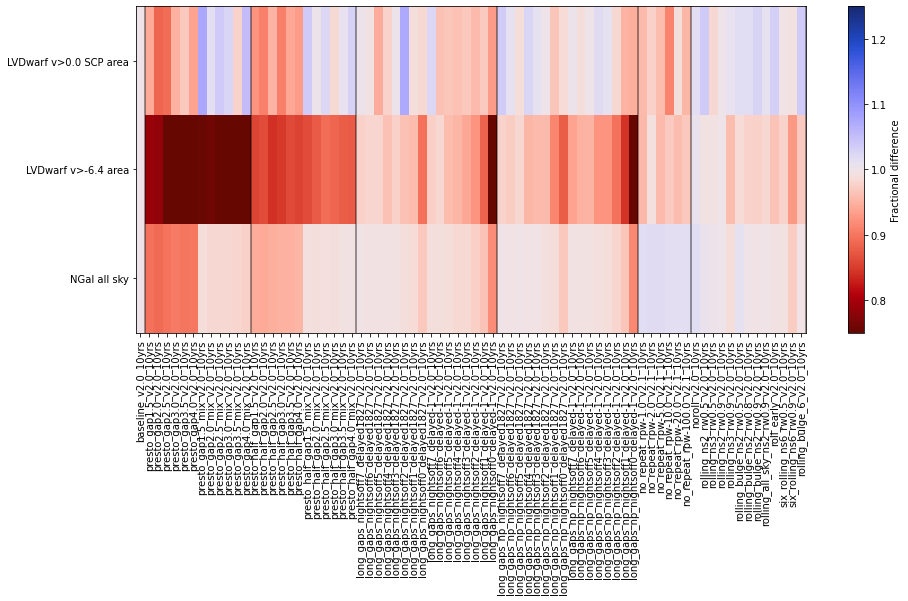

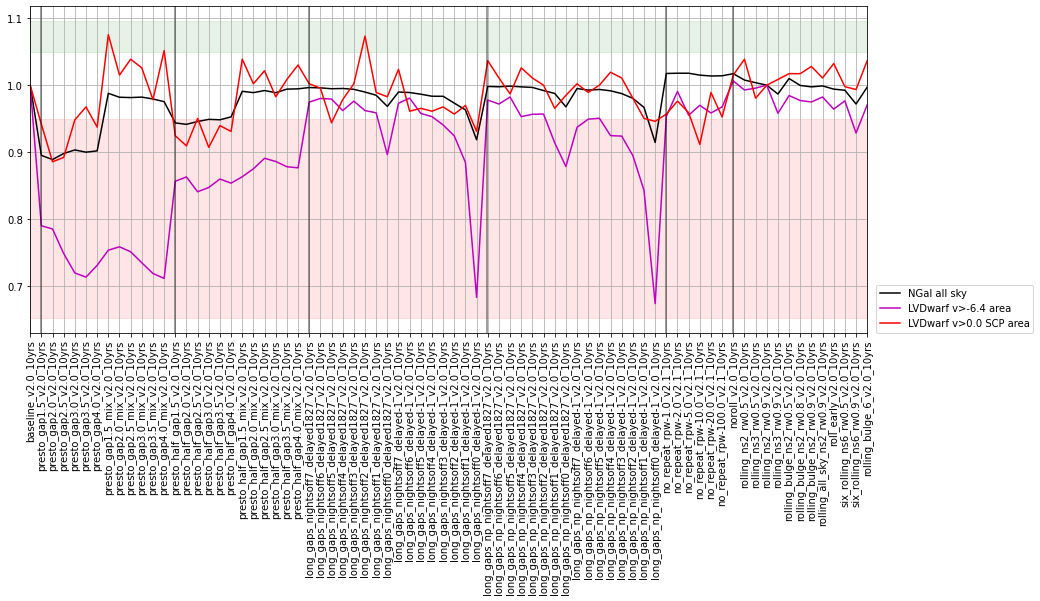

In [60]:
k = 'galaxies'

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_sets.loc[k]['short_name'],
                                   metric_set=metric_sets.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

msub = metric_sets.loc[k]
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']], 
                              baseline_run=baseline_run,
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

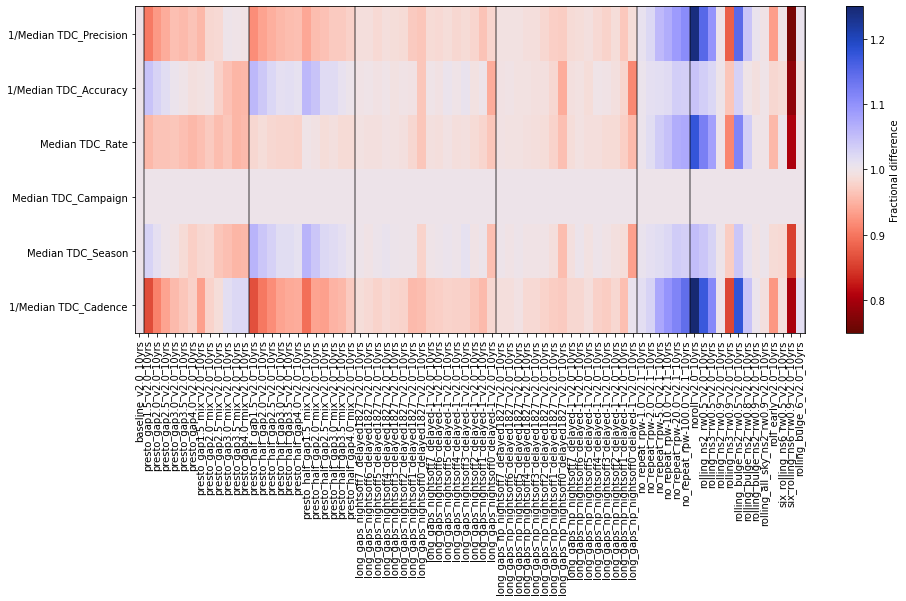

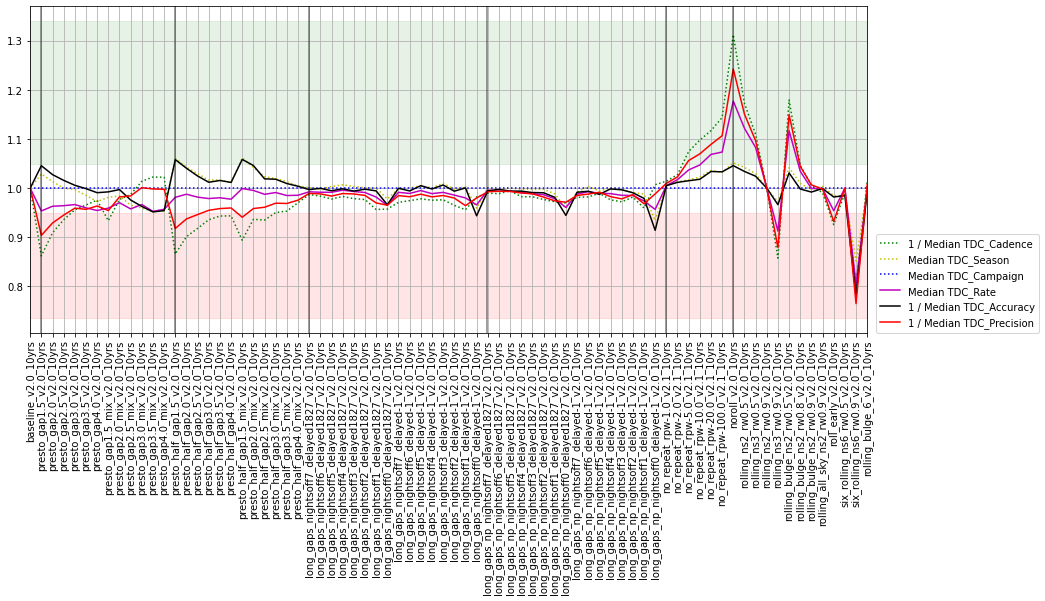

In [61]:
k = 'SL TDC'

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_sets.loc[k]['short_name'],
                                   metric_set=metric_sets.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)

msub = metric_sets.loc[k]
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']], 
                              baseline_run=baseline_run,
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')
for l in lines:
    ax.axvline(l-0.05, color='k', alpha=0.5)

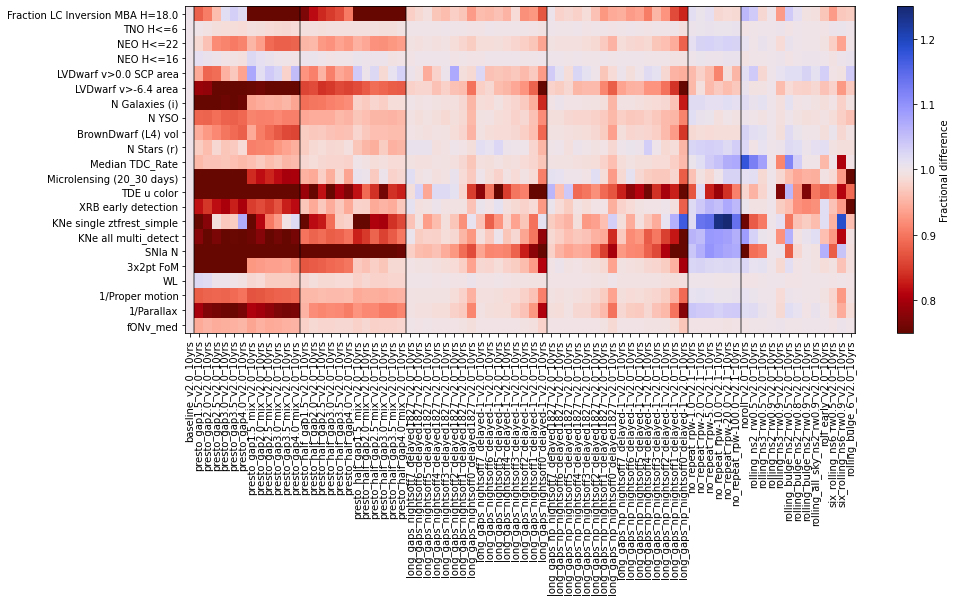

In [62]:
k = 'SCOC'

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=metric_sets.loc[k]['short_name'],
                                   metric_set=metric_sets.loc[k],
                                  color_range=0.5)
fig.set_figwidth(15)
for l in lines:
    ax.axvline(l, color='k', alpha=0.5)


Overcoming the slewtime penalties with the triplets is hard. 